In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
# from pandas_profiling import ProfileReport
import numpy as np
import warnings
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

ROOT = os.environ.get('PWD')

warnings.filterwarnings('ignore')






# Data cleaning and feature engineering

In [ ]:
# set global default to be able to see all columns

pd.set_option('display.max_rows', None)

In [2]:
# read from csv

master = pd.read_csv('../data/super_master.csv')

In [ ]:
list(master.columns.values)

In [3]:
# drop necessary columns
drop_list = ['Unnamed: 0','Unnamed: 0.1','Unnamed: 0_x','Unnamed: 0_y','arrival_date']

for i in drop_list:
    master.drop([i],axis=1,inplace=True)

In [ ]:
master.nunique()

In [6]:
# select the filter that is appropriate for the data range. 
# NOTE: the range is not automatically reflected in the name of the dataframe--
# but it should be put into the parameters for ML Flow

# by default, the master set has both years, 2019 and 2020, so it needs no filter

# master_filter = master

# to filter only 2019 data
master_filter = master.query('year == 2019')

# to filter only 2020 data
# master_filter = master.query('year == 2020')

In [7]:
master_filter.tail()

,listing_id,top,year,month,inquiry_count,children`s_room,corridor,dining_room,kitchen,kitchen_living,...,garden,balcony,bathrooms,bedrooms,max_guests,living_area,lat,lng,filled_in_price_per_day,inquiry_rate
6080430,55851128-00df-55ff-ad59-b3d7ea6fef39,1.0,2019,12,1,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,4.0,112.0,54.409413,9.034851,95.0,0.01
6080431,55851128-00df-55ff-ad59-b3d7ea6fef39,1.0,2019,12,1,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,4.0,112.0,54.409413,9.034851,95.0,0.01
6080432,55851128-00df-55ff-ad59-b3d7ea6fef39,1.0,2019,12,1,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,4.0,112.0,54.409413,9.034851,95.0,0.01
6080433,55851128-00df-55ff-ad59-b3d7ea6fef39,1.0,2019,12,1,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,4.0,112.0,54.409413,9.034851,95.0,0.01
6080434,55851128-00df-55ff-ad59-b3d7ea6fef39,1.0,2019,12,1,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,4.0,112.0,54.409413,9.034851,95.0,0.01


In [ ]:
master_filter.isna().sum()

## the data set has no missing values

# we now need to normalize on time to remove seasonality 



In [8]:
import math 

# We normalize x values to match with the 0-2π cycle
master_filter["month_norm"] = 2 * math.pi * master_filter["month"] / master_filter["month"].max()

master_filter["cos_month"] = np.cos(master_filter["month_norm"])
master_filter["sin_month"] = np.sin(master_filter["month_norm"])

In [ ]:
master_filter["month_norm"]

In [9]:
# save filtered, normed to csv

master_filter.to_csv('../data/master_filter.csv')

In [2]:
# read filtered, normed time data
#  
master_filter = pd.read_csv('../data/master_filter.csv')

In [3]:
# generate the feature mean_price_per_day 

master_filter_price_agg = master_filter.groupby(['listing_id','month']).agg(['mean'])['filled_in_price_per_day'].reset_index()

In [ ]:
master_filter_price_agg.head(2)

In [4]:

master_filter_1 = pd.merge(master_filter_price_agg, master_filter, left_on=['listing_id','month'], right_on=['listing_id','month'], how='right')

In [5]:
master_filter_1.rename(columns={'mean':'mean_price_per_day'},inplace=True)

In [ ]:
list(master_filter_1.columns.values)

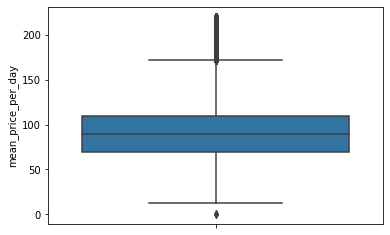

In [15]:
# check boxplots for mean max min
import seaborn as sns
import matplotlib as plt

sns.boxplot( y=master_filter_1['mean_price_per_day'] );


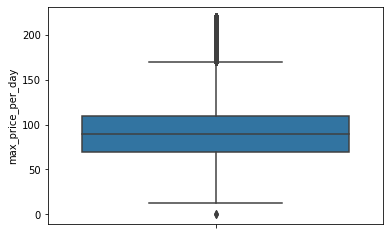

In [16]:
sns.boxplot( y=master_filter_1['max_price_per_day'] );

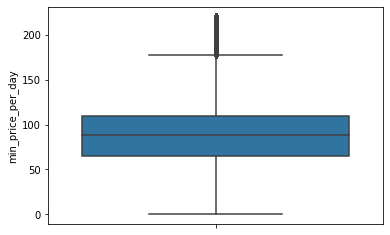

In [17]:
sns.boxplot( y=master_filter_1['min_price_per_day'] );

In [8]:
list(master_filter_1.columns.values)

['listing_id',
 'mean_price_per_day',
 'Unnamed: 0',
 'top',
 'inquiry_count',
 'children`s_room',
 'corridor',
 'dining_room',
 'kitchen',
 'kitchen_living',
 'living_bedroom',
 'living_/_dining_room',
 'living_room',
 'separate_WC',
 'storage_room',
 'washroom',
 'wellness',
 'Blu-ray_player',
 'CDs_DVDs',
 'DVD-player',
 'additional_bed',
 'armchair',
 'awning_',
 'bath_towels',
 'bathtub',
 'beach_chair',
 'bed_linen',
 'bicycles',
 'books',
 'bread_service',
 'bunk_bed',
 'carport',
 'central_heating',
 'chest_of_drawers',
 "child's_bed",
 'children_toilet_seat',
 'cleaning_supplies',
 'coffee_machine',
 'colouring_book_pencils',
 'crockery',
 'desk',
 'dining_table',
 'double_bed',
 'double_wash_basin',
 'drying_rack',
 'egg_cooker',
 'fire_alarm',
 'fireplace',
 'first-aid_kit',
 'flat_iron',
 'fly_screen',
 'food_processor',
 'freezer',
 'games',
 'garage',
 'garden_furniture',
 'garden_shed',
 'hair_dryer',
 'high_chair',
 'hot_water',
 'ironing_board',
 'kettle',
 'laundry_se

In [7]:
# drop more things that need not be in the data set

drop_list = ['filled_in_price_per_day','option_wheelchair_accessible','option_family_travel',
'option_close_to_the_water','option_holiday_with_your_baby',
 'option_long_term_holiday',
 'option_fully_accessible',
 'option_technicians',
 'option_close_to_the_ski_lift','max_price_per_day',
 'min_price_per_day','month_norm','year','month',
 'option_holiday_with_your_dog','option_holiday_with_your_horse']

for i in drop_list:
    master_filter_1.drop([i],axis=1,inplace=True)

In [26]:
# save to csv if desired: this is the normed, filtered set with agg price data for the years in question

master_filter_1.to_csv('../data/master_filter_price_agg.csv')

In [3]:
master_filter_1 = pd.read_csv('../data/master_filter_price_agg.csv')

In [9]:
master_filter_1['property_type'].unique()

array(['holiday_apartment', 'holiday_houses'], dtype=object)

In [10]:
# convert property types into binary: holiday apartment = 0, and holiday_houses = 1
master_filter_1['prop_bin'] = 1


In [11]:
master_filter_1.loc[master_filter_1['property_type'] == 'holiday_apartment', 'prop_bin'] = 0

In [30]:
master_filter_1.head()

,listing_id,mean_price_per_day,top,inquiry_count,children`s_room,corridor,dining_room,kitchen,kitchen_living,living_bedroom,...,bedrooms,max_guests,living_area,lat,lng,filled_in_price_per_day,inquiry_rate,cos_month,sin_month,prop_bin
0,c5c0fcff-faf3-5a07-a0d9-fe2857025cd8,65.0,0.0,1,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,2.0,60.0,53.626845,7.293929,65.0,0.04,0.866025,0.500000,0
1,6ec2303b-5083-50ef-bead-9e3d839f3caa,55.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,4.0,65.0,53.207069,7.986032,55.0,0.02,0.866025,0.500000,1
2,bfeddf97-945f-5cd4-96e4-dcbe170e8410,54.0,0.0,1,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,40.0,53.938466,10.678566,54.0,0.01,0.866025,0.500000,0
3,1c883ca8-3a96-56b0-b8e9-1d9f7f4a9180,60.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,81.0,51.271444,8.546197,60.0,0.02,0.500000,0.866025,0
4,e8224b68-1c9b-5464-8c28-565798996ea5,50.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,3.0,45.0,49.343352,8.109466,50.0,0.01,0.500000,0.866025,0


In [13]:
# more drops
drop_list =['property_type','Unnamed: 0']

for i in drop_list:
    master_filter_1.drop([i],axis=1,inplace=True)

In [14]:
master_filter_1['title'].unique()

array(['Anfrage', 'Verbindliche Anfrage', 'Externe Buchung',
       'Direktbuchen'], dtype=object)

In [15]:
# trying not to be a dummy by getting dummies

master_dummies = pd.get_dummies(master_filter_1, columns=['holiday_region','title'])

In [16]:
# save to csv if desired: this is the normed, filtered set with agg price data for the years in question

master_dummies.to_csv('../data/master_with_dummies.csv')

In [17]:
# free up memory

import gc
del master_filter_1
gc.collect()

6570

In [18]:
# create X and Y sets for train test split

X = master_dummies.drop(['listing_id','inquiry_count'],axis=1)
Y = master_dummies['inquiry_count']

In [19]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [20]:
# we love to normalize our data!!

from sklearn.preprocessing import MinMaxScaler


In [21]:
the_list = ['mean_price_per_day','adult_count','children_count','pets_count','length_stay','bathrooms','bedrooms','max_guests','living_area']

In [22]:
# Scaling with MinMaxScaler
scaler_norm = MinMaxScaler()
X_train_scaled_norm = scaler_norm.fit_transform(X_train[the_list])
X_test_scaled_norm = scaler_norm.transform(X_test[the_list])

In [23]:
# Concatenating normalized columns 
X_train_preprocessed_norm = np.concatenate([X_train_scaled_norm, X_train.drop(the_list, axis=1)], axis=1)
X_test_preprocessed_norm = np.concatenate([X_test_scaled_norm, X_test.drop(the_list, axis=1)], axis=1)

In [24]:
X_train_preprocessed_norm.shape

(1316826, 164)

In [25]:
X_test_preprocessed_norm.shape

(564354, 164)

## Trainining the model and tracking with MLFlow

In [26]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [27]:
print("Active run_id: {}".format(run.info.run_id))

Active run_id: 846018c597f94904a0fb62a9381aa119


In [28]:
#training the model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_preprocessed_norm, y_train)

In [29]:
from sklearn.metrics import mean_squared_error
y_train_pred = reg.predict(X_train_preprocessed_norm)
rmse_train = mean_squared_error(y_train, y_train_pred,squared=False)
print(rmse_train)

36.27805630229738


In [30]:
y_test_pred = reg.predict(X_test_preprocessed_norm)
rmse_test = mean_squared_error(y_test, y_test_pred,squared=False)
print(rmse_test)

36.234546132696565


In [31]:
params = {
      "year":'2019',
      "train_test_split": 30,
      "normalized data": 'yes',
      "metric": 'rmse'
  }

SyntaxError: invalid syntax (2516774727.py, line 3)

In [ ]:
mlflow.log_params(params)
mlflow.set_tag("running_from_jupyter", "baseline model 2019")
mlflow.log_metric("train -" + "RMSE", rmse_train)
mlflow.log_metric("test -" + "RMSE", rmse_test)
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

In [ ]:
mlflow.get_run(run_id=run.info.run_id)

## Checking the experiments

while the next cell is running you will not be able to run other cells in the notebook

In [ ]:
!mlflow ui